# **Case Study: Increase Coffee Cups Sales**

## *Importing and Exploring Raw Data*

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
coffee = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/coffee.csv')
coffee.columns = coffee.columns.str.replace(' ', '_')
display(coffee.head())
print(coffee.shape)
print(coffee.info()) 
print(coffee.describe())
coffee.isna().sum()

,Region,Place_name,Place_type,Rating,Reviews,Price,Delivery_option,Dine_in_option,Takeout_option
0,C,Dim Kavu,Others,4.6,206.0,$$,False,NaN,NaN
1,C,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,C,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,False,NaN,True
3,C,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,C,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,$$,False,True,True


(200, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place_name       200 non-null    object 
 2   Place_type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            200 non-null    object 
 6   Delivery_option  200 non-null    bool   
 7   Dine_in_option   140 non-null    object 
 8   Takeout_option   144 non-null    object 
dtypes: bool(1), float64(2), object(6)
memory usage: 12.8+ KB
None
           Rating       Reviews
count  198.000000    198.000000
mean     4.663636    622.494949
std      0.221648   1400.898666
min      3.900000      3.000000
25%      4.600000     47.500000
50%      4.700000    271.500000
75%      4.800000    786.250000
max      5.000000  17937.000000


Region              0
Place_name          0
Place_type          0
Rating              2
Reviews             2
Price               0
Delivery_option     0
Dine_in_option     60
Takeout_option     56
dtype: int64

## *Data Cleaning Workflow*
- There are unneeded columns we can remove that do not affect our analysis.
- There are 2 shops that have null values for **Reviews** and **Ratings** we need to look at.
- Addressing outliers within **Reviews** to get a better calculation of summary statistics. 
- There are no duplicated rows within this dataset

### **Dropping Columns**
- Removing columns (Delivery_option, Dine_in_option, Takeout_option) since they have no immediate affect on our analysis for **Reviews** for different coffee seller locations. 

In [74]:
coffee = coffee.drop(columns=['Delivery_option', 'Dine_in_option', 'Takeout_option'])

### **Capping Outliers**

- Outliers will be calculated and capped using the IQR since the distribution of **Reviews** is skewed right. 

<AxesSubplot:ylabel='Frequency'>

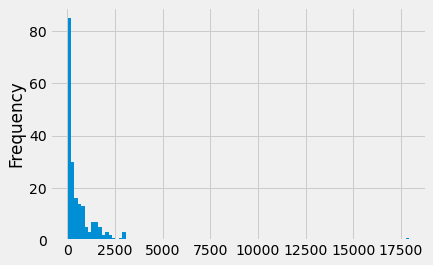

In [75]:
coffee['Reviews'].plot(kind='hist',bins=100)

In [76]:
import numpy as np
percentile25 = coffee['Reviews'].quantile(0.25)
percentile75 = coffee['Reviews'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
coffee_clean = coffee.copy()
coffee_clean['Reviews'] = np.where(
    coffee_clean['Reviews'] > upper_limit,
    upper_limit,
    np.where(
        coffee_clean['Reviews'] < lower_limit,
        lower_limit,
        coffee_clean['Reviews']
    )
)

### **Imputing NaN values**
- Examine minimum and maximum values for **Reviews** as well as looking at rows where **Reviews** and **Rating** are empty.
- Using the groupby function to fill the missing values in **Reviews** and **Rating** by agggregating in regards to the mean based on (Place_type, Region, Price)

In [86]:
display(coffee[coffee.Reviews == coffee.Reviews.max()])
display(coffee[coffee.Reviews == coffee.Reviews.min()])
display(coffee[(coffee.Rating.isnull())|(coffee.Reviews.isnull())])

,Region,Place_name,Place_type,Rating,Reviews,Price
100,E,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,$$


,Region,Place_name,Place_type,Rating,Reviews,Price
170,I,"Dom Kofe, Mah.",Coffee shop,4.3,3.0,$$


,Region,Place_name,Place_type,Rating,Reviews,Price
49,F,Кофе В Херсоне,Cafe,NaN,NaN,$$
186,H,"Coffee&Cake, Game zone PS4",Coffee shop,NaN,NaN,$$


In [9]:
coffee_clean["Rating"] = coffee_clean.groupby(['Place_type','Region','Price'])['Rating'].transform(lambda x: x.fillna(x.mean()))
coffee_clean["Reviews"] = coffee_clean.groupby(['Place_type','Region','Price'])['Reviews'].transform(lambda x: x.fillna(x.mean()))
coffee_clean.describe()


,Rating,Reviews
count,200.000000,200.000000
mean,4.663667,515.063958
std,0.220557,583.071119
min,3.900000,3.000000
25%,4.600000,48.500000
50%,4.700000,277.000000
75%,4.800000,793.250000
max,5.000000,1894.375000


### **Duplicated Observations**
- The duplicated values for **Place_name** show differences in region and place type so there is no need to remove these observations.

In [87]:
coffee_clean[coffee_clean['Place_name'].duplicated()]


,Region,Place_name,Place_type,Rating,Reviews,Price
68,B,Coffee House,Others,4.7,132.0,$$
97,A,MY COFFEE,Coffee shop,4.8,150.0,$$
107,E,Svit Kavy,Coffee shop,4.3,102.0,$$
108,E,Lviv Coffee Manufacture,Coffee shop,4.5,778.0,$$
112,E,coffee House,Coffee shop,4.7,363.0,$$
132,D,SV Кафе,Cafe,4.6,740.0,$$
154,G,Kaffa,Espresso bar,4.8,824.0,$$
161,I,Coffee House,Espresso bar,4.5,268.0,$$
167,I,coffee House,Cafe,4.6,96.0,$$
171,I,Dim Kavy,Espresso bar,4.7,185.0,$$


## *Data Exploration and Visualization*

In [203]:
coffee.Place_type.unique()

array(['Others', 'Cafe', 'Coffee shop', 'Espresso bar'], dtype=object)

In [ ]:
coffee.Place_type.value_counts()

Coffee shop     97
Cafe            58
Others          25
Espresso bar    20
Name: Place_type, dtype: int64

Text(0.5, 1.0, 'Greatest Types of Coffee Locations')

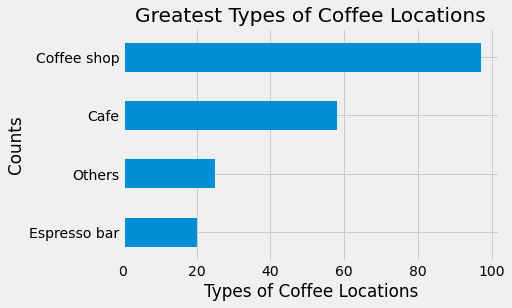

In [12]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
coffee_clean.Place_type.value_counts(ascending=True).plot(kind='barh')
plt.ylabel('Counts')
plt.xlabel('Types of Coffee Locations')
plt.title('Greatest Types of Coffee Locations')

The marketing team should focus on coffee shops since they have the highest number of locations. Another consideration would be choosing cafe's since they represent more tahn half of the coffee shops. 

Text(0.5, 1.0, 'Range of Reviews Across Shops')

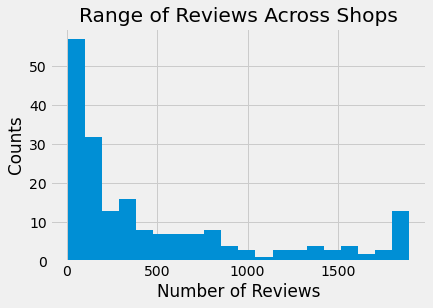

In [100]:
coffee_clean['Reviews'].plot(kind='hist', bins=20)
plt.ylabel('Counts')
plt.xlabel('Number of Reviews')
plt.title('Range of Reviews Across Shops')

The marketing team should focus on Shops where the reviews are greater than the 75 percentile value of 793, while focusing on shops with higher amount of reviews. It may be nesscary for the marketing team to go as low as the mean for the amount of reviews (515). This will depend on how many shops the marketing team want to partner with. 

Text(0, 0.5, 'Number of Reviews')

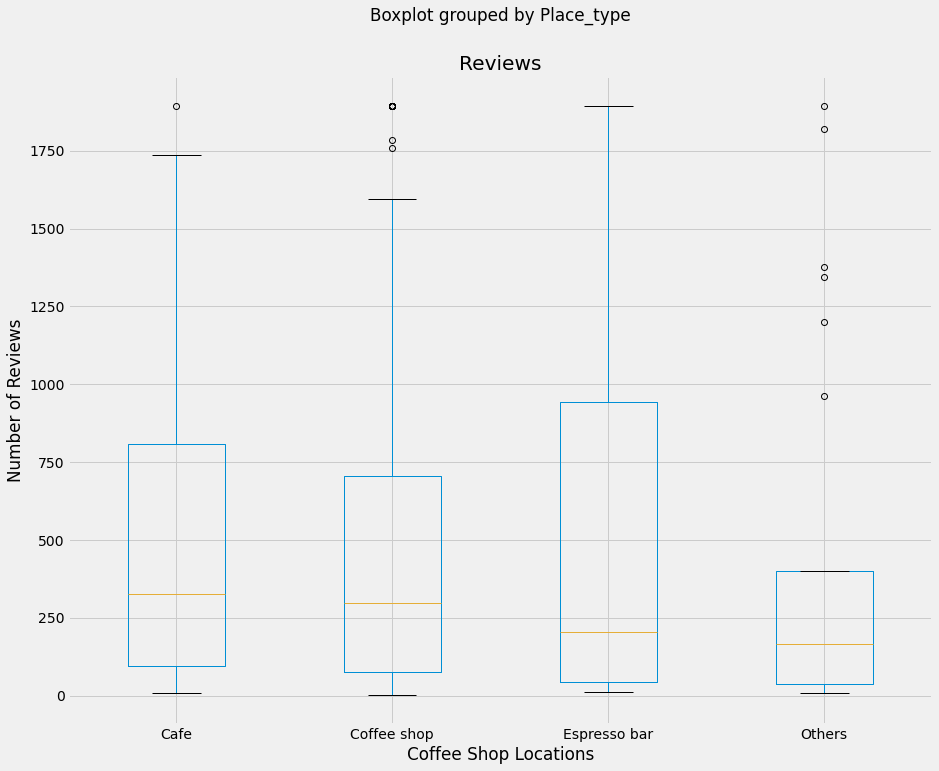

In [131]:
coffee_clean.boxplot(by='Place_type',column='Reviews', figsize=(15,12))
plt.xlabel('Coffee Shop Locations')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Across Place type'